In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-11-30 00:44:07.485348: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-30 00:44:07.535024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-30 00:44:07.535065: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-30 00:44:07.535091: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-30 00:44:07.548236: I tensorflow/core/platform/cpu_feature_g

In [2]:
from tools.visualization import plot_image
from tools.data_loading import load_numpy_data
from defs.storage_locs import ALL_DATASETS_NAMES, weights_file

# Load Data

In [11]:
test_filename = 'test'
train_filename = 'train'
input_dirname = '224x224_sized'
shape = '224x224'

In [12]:
test_X, test_Y = load_numpy_data(test_filename, shape, save=False, input_dirname=input_dirname)
train_X, train_Y = load_numpy_data(train_filename, shape, save=False, input_dirname=input_dirname)
weights_filename = 'MobileNetV3Small_all.h5'

In [9]:
print(test_X.shape)
print(test_Y.shape)

(372, 224, 224, 3)
(372, 20)


In [20]:
points = [1,2,3,4,5,6] # points to be predicted
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
test_Y = test_Y[:, point_cols]
train_Y = train_Y[:, point_cols]
print(test_Y.shape)

(372, 12)


# Define and Load Model

In [21]:
shape = test_X[0].shape
print(shape)
num_outputs = test_Y.shape[1]
print(num_outputs)

(224, 224, 3)
12


In [23]:
bm = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    input_shape=shape,
)
inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x = tf.keras.layers.Conv2D(2048, (3, 3), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_outputs, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 28224)             0         
                                                                 
 dropout_2 (Dropout)         (None, 28224)             0         
                                                                 
 dense_2 (Dense)             (None, 12)                338700    
                                                                 
Total params: 1277820 (4.87 MB)
Trainable params: 1265708 (4.83 MB)
Non-trainable params: 12112 (47.31 KB)
__________________

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])

In [25]:
# load weights
print(weights_file(weights_filename))
model.load_weights(weights_file(weights_filename))

/mnt/f/SeniorProject/weights/MobileNetV3Small_all.h5


# Predictions

In [26]:
train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)

2023-11-30 00:59:33.328434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-30 00:59:37.679845: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 1/45 [..............................] - ETA: 7:43

2023-11-30 00:59:38.944094: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


12/12 [==============================] - 0s 25ms/step


## Collect Statistics

In [27]:
# MSE
train_mse = np.mean(np.square(train_predictions - train_Y))
test_mse = np.mean(np.square(test_predictions - test_Y))
print('train_mse:', train_mse)
print('test_mse:', test_mse)

train_mse: 336.75787
test_mse: 991.0486


In [28]:
train_mae = np.mean(np.abs(train_predictions - train_Y))
test_mae = np.mean(np.abs(test_predictions - test_Y))
print('train_mae:', train_mae)
print('test_mae:', test_mae)

train_mae: 10.129539
test_mae: 20.640226


In [29]:
train_max_avg_error = np.mean(np.max(np.abs(train_predictions - train_Y), axis=1))
test_max_avg_error = np.mean(np.max(np.abs(test_predictions - test_Y), axis=1))
print('train_max_avg_error:', train_max_avg_error)
print('test_max_avg_error:', test_max_avg_error)

train_max_avg_error: 34.846897
test_max_avg_error: 56.107956


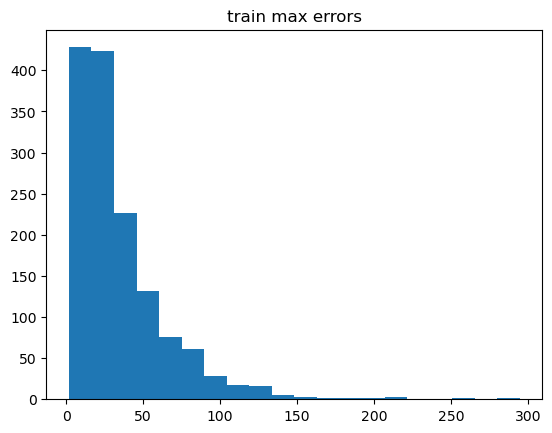

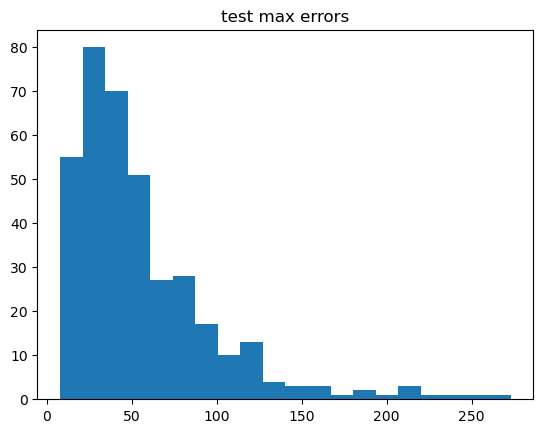

In [30]:
# histogram of max errors
train_max_errors = np.max(np.abs(train_predictions - train_Y), axis=1)
test_max_errors = np.max(np.abs(test_predictions - test_Y), axis=1)
plt.hist(train_max_errors, bins=20)
plt.title('train max errors')
plt.show()
plt.hist(test_max_errors, bins=20)
plt.title('test max errors')
plt.show()

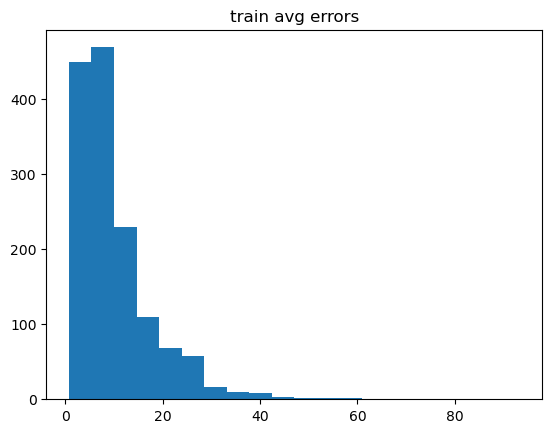

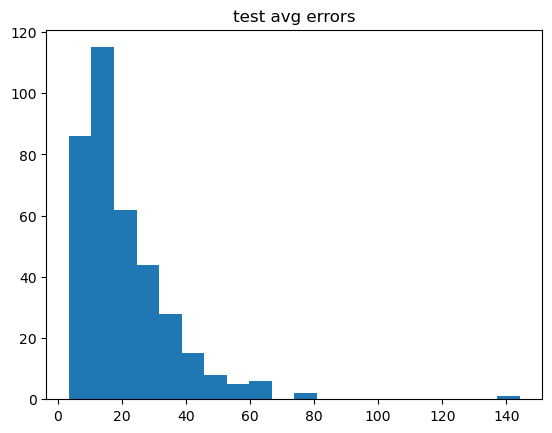

In [31]:
# histogram of avg errors
train_avg_errors = np.mean(np.abs(train_predictions - train_Y), axis=1)
test_avg_errors = np.mean(np.abs(test_predictions - test_Y), axis=1)
plt.hist(train_avg_errors, bins=20)
plt.title('train avg errors')
plt.show()
plt.hist(test_avg_errors, bins=20)
plt.title('test avg errors')
plt.show()

## See worst predictions

In [32]:
from court_segment.plot_court_labels import plot_labels

### Worst max

In [33]:
count = 5
worst_train_indices = np.argsort(train_max_errors)[-count:][::-1]
worst_test_indices = np.argsort(test_max_errors)[-count:][::-1]
print('worst train indices:', worst_train_indices)
print('worst test indices:', worst_test_indices)
print('train max errors:', train_max_errors[worst_train_indices])
print('test max errors:', test_max_errors[worst_test_indices])

worst train indices: [785 145 438 354 650]
worst test indices: [ 13 138  14 158 121]
train max errors: [294.6156  253.53076 214.37122 209.2373  208.82971]
test max errors: [273.04443 259.3028  241.22644 222.43982 215.83325]


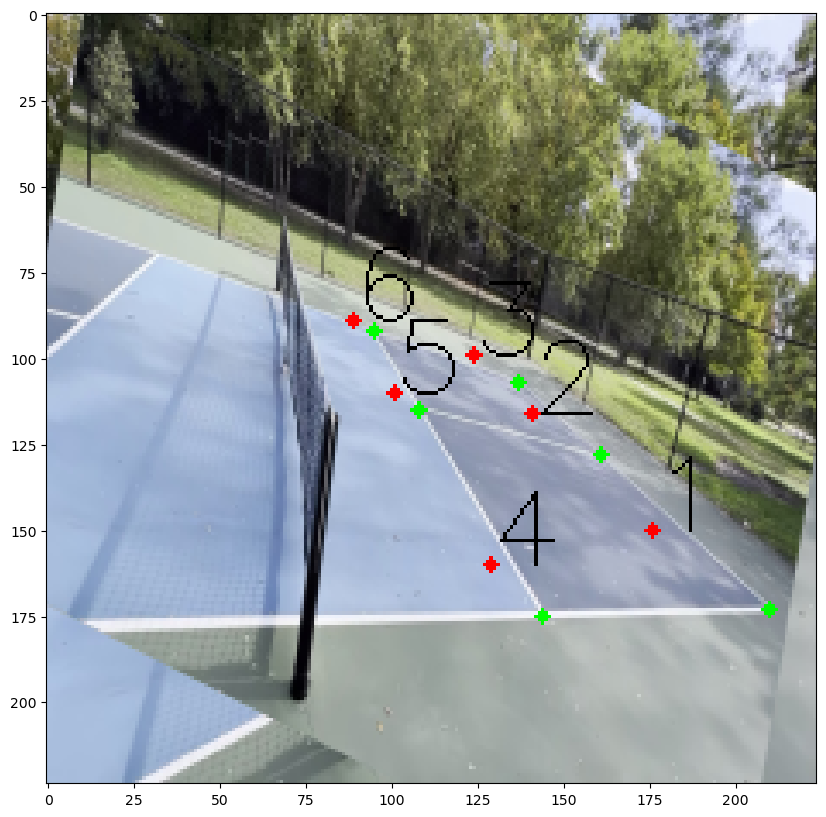

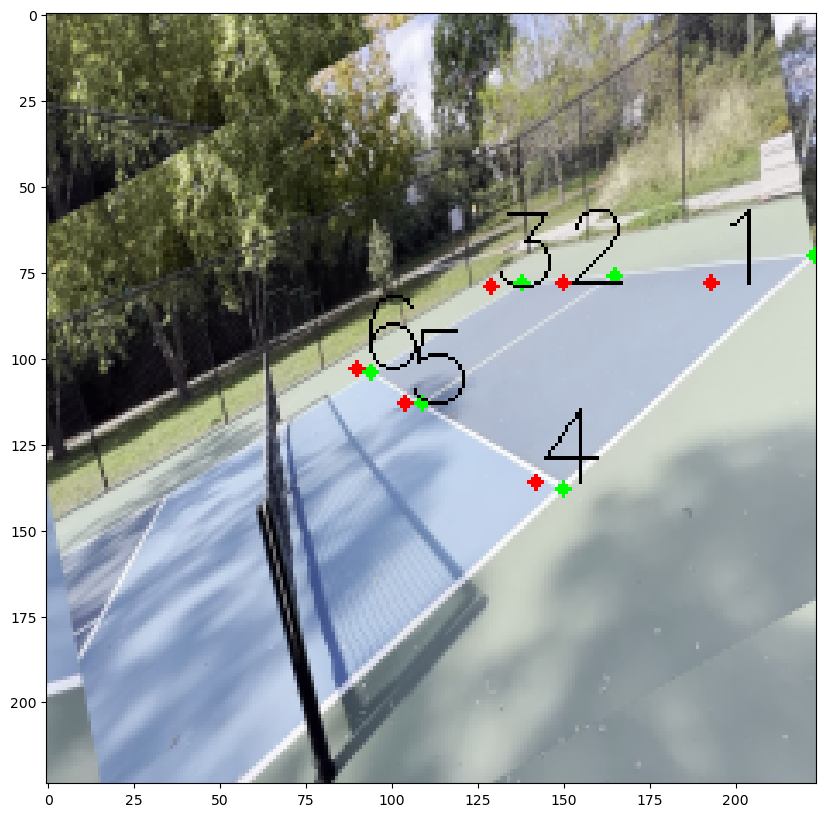

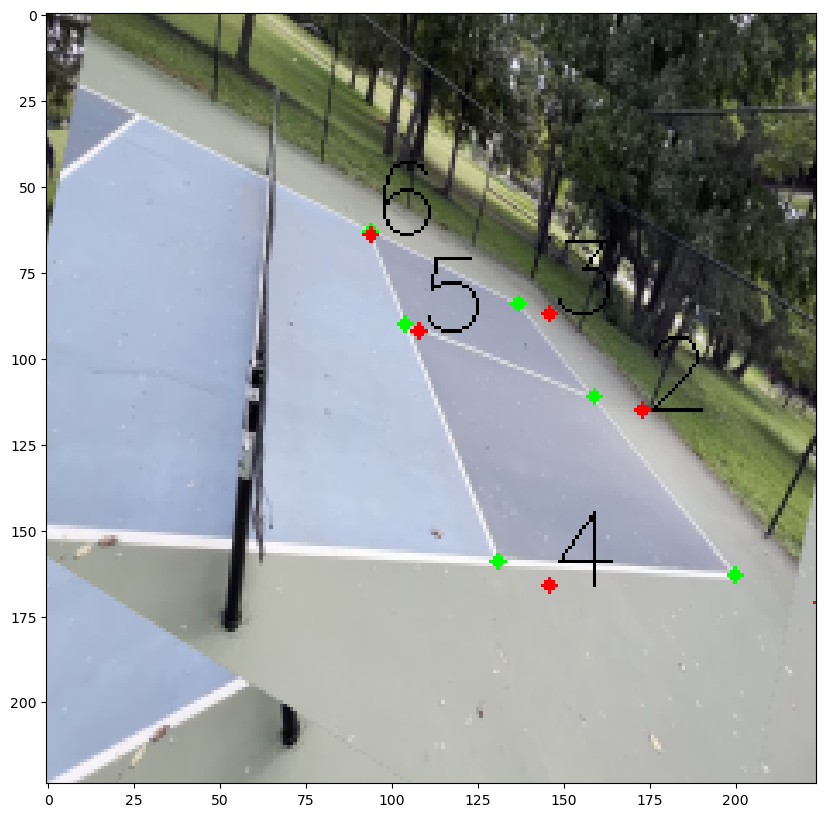

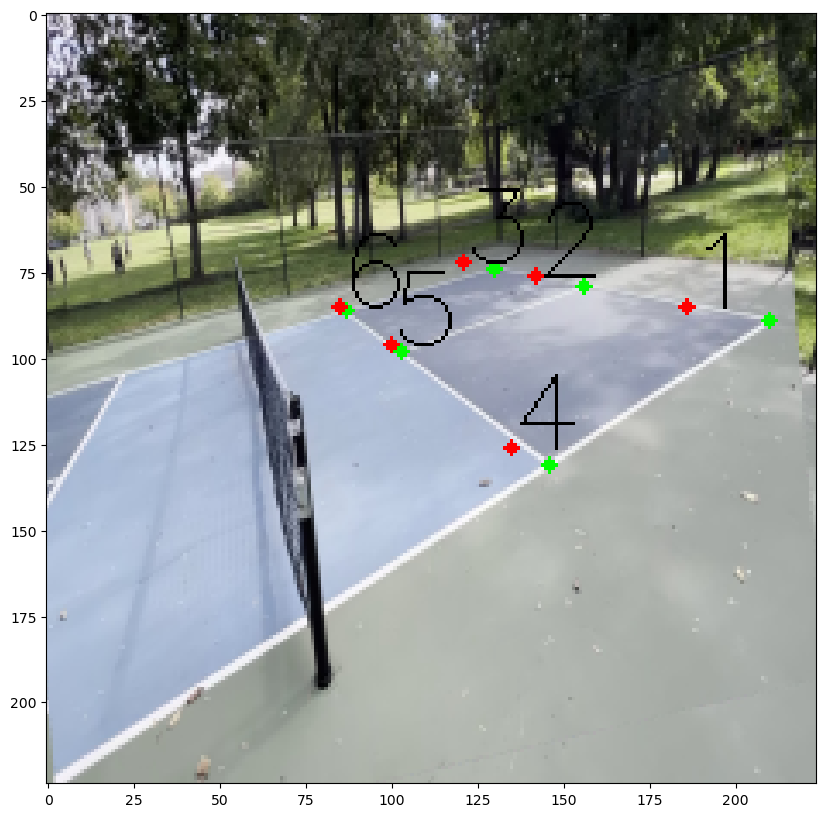

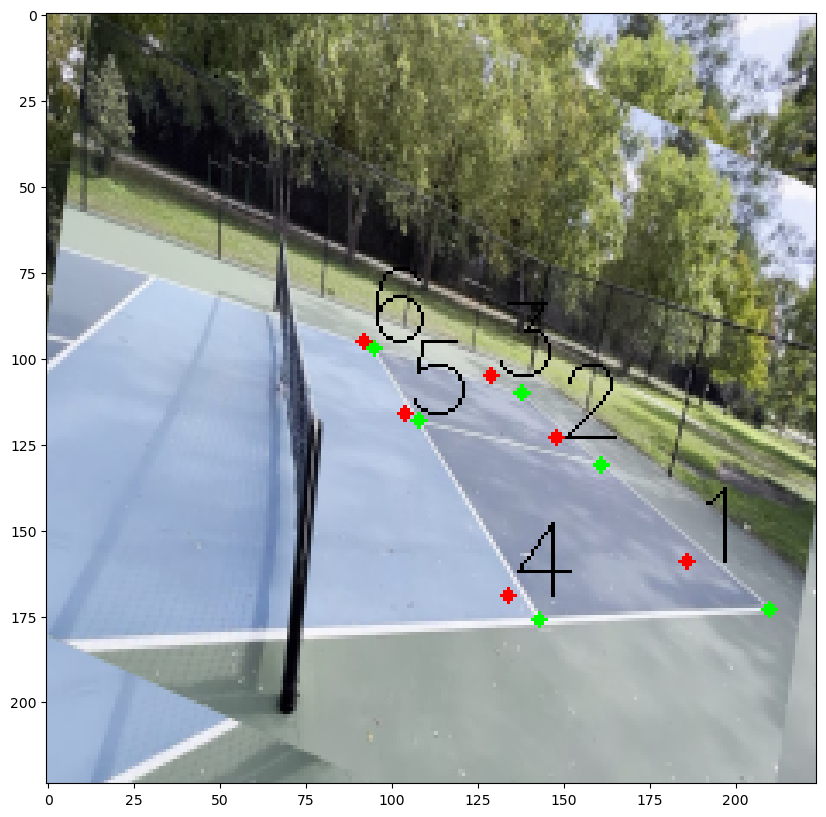

In [34]:
for i in worst_train_indices:
    correct_labels = plot_labels(train_X[i], train_Y[i], withText=False)
    all_labels = plot_labels(correct_labels, train_predictions[i], color=(255, 0,0))
    plot_image(all_labels)

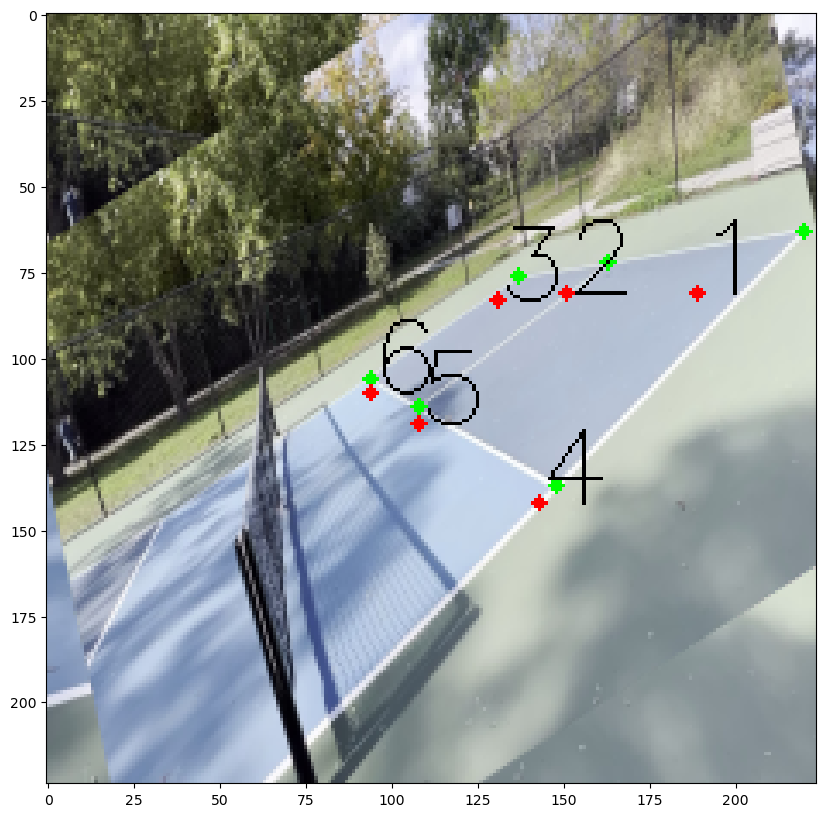

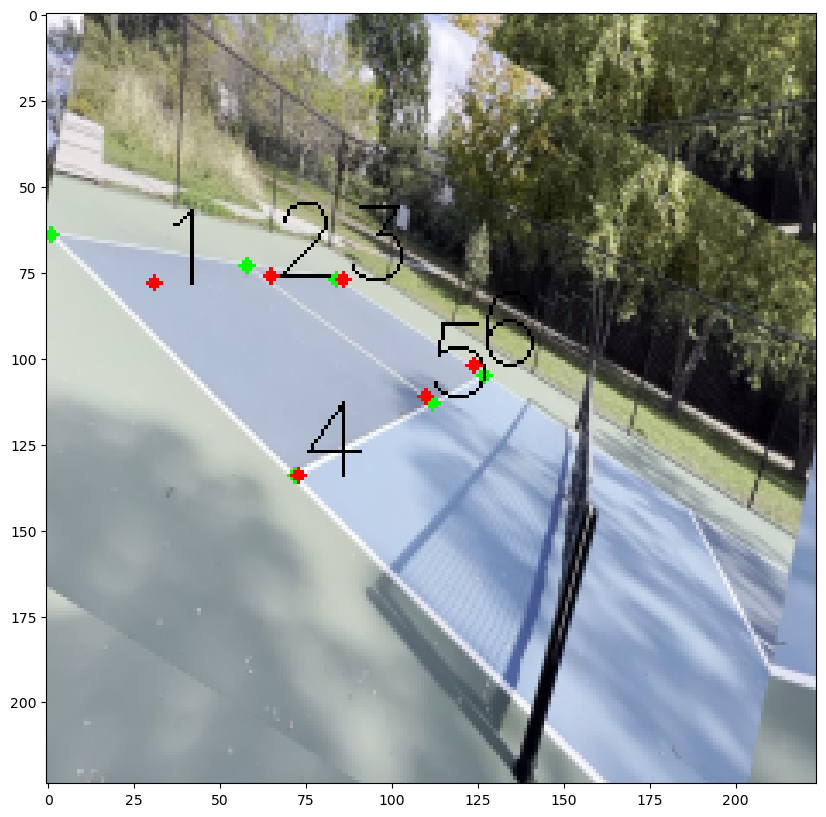

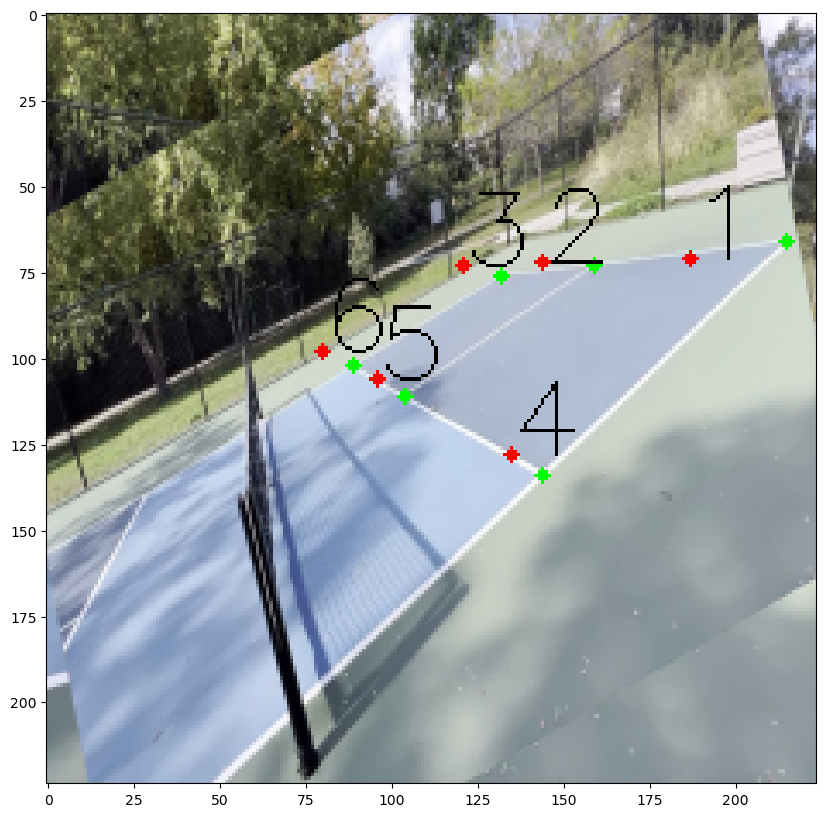

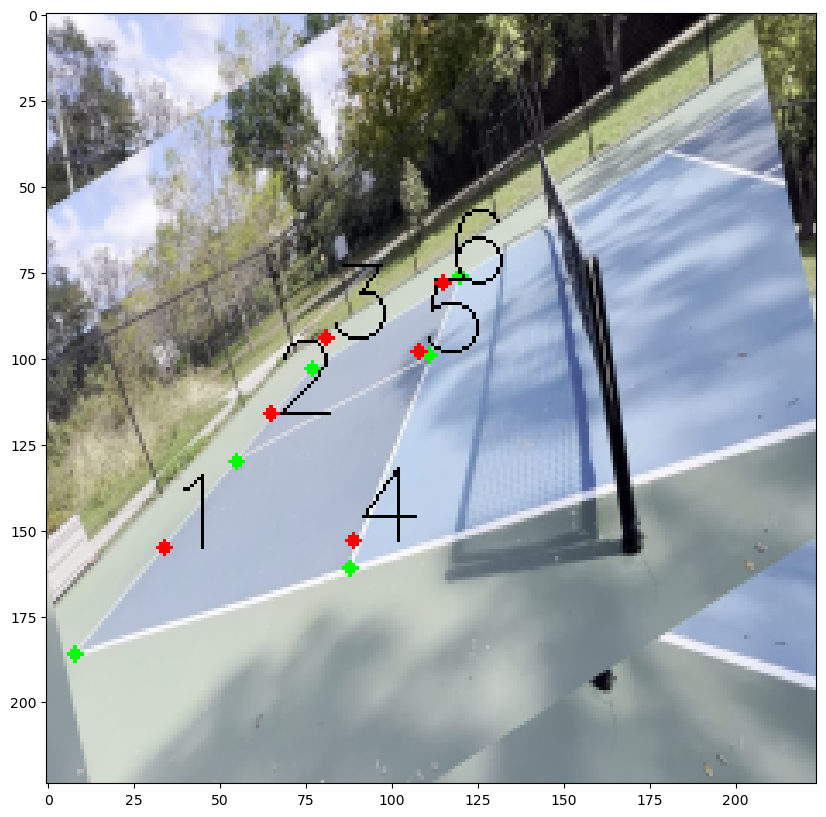

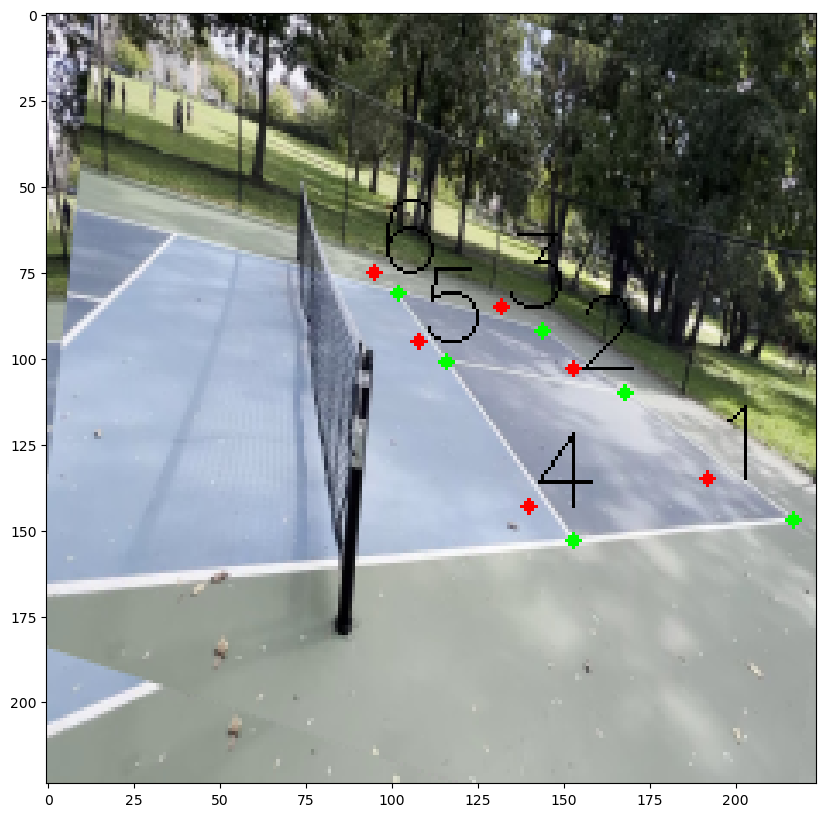

In [35]:
for i in worst_test_indices:
    correct_labels = plot_labels(test_X[i], test_Y[i], withText=False)
    all_labels = plot_labels(correct_labels, test_predictions[i], color=(255,0,0))
    plot_image(all_labels)

### Worst Average

In [36]:
count = 5
worst_train_indices = np.argsort(train_avg_errors)[-count:][::-1]
worst_test_indices = np.argsort(test_avg_errors)[-count:][::-1]
print('worst train indices:', worst_train_indices)
print('worst test indices:', worst_test_indices)
print('train avg errors:', train_avg_errors[worst_train_indices])
print('test avg errors:', test_avg_errors[worst_test_indices])

worst train indices: [785 971 344 650 438]
worst test indices: [131 121  68 201  87]
train avg errors: [93.36826  74.3252   61.828266 58.86128  56.798275]
test avg errors: [144.15778   76.306114  74.03441   66.068184  65.3937  ]


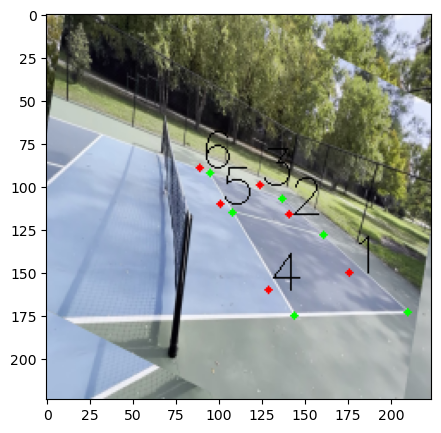

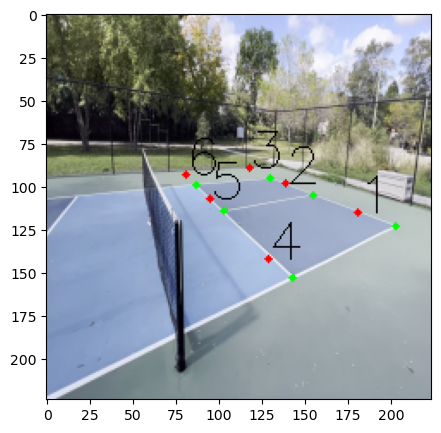

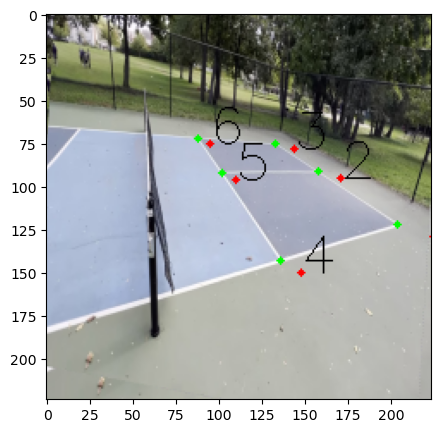

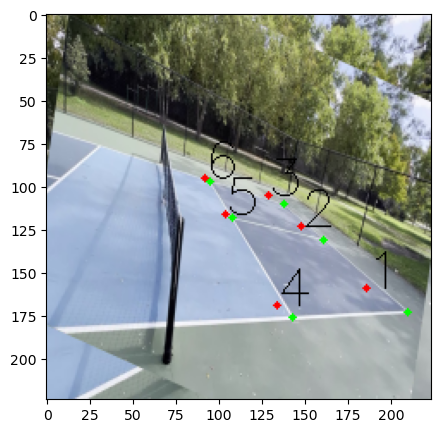

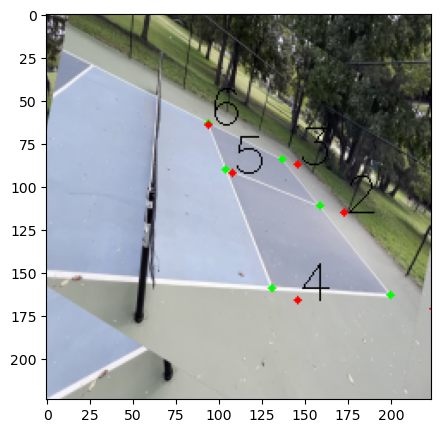

In [37]:
for i in worst_train_indices:
    correct_labels = plot_labels(train_X[i], train_Y[i], withText=False)
    all_labels = plot_labels(correct_labels, train_predictions[i], color=(255,0,0))
    plot_image(all_labels, figsize=(5,5))

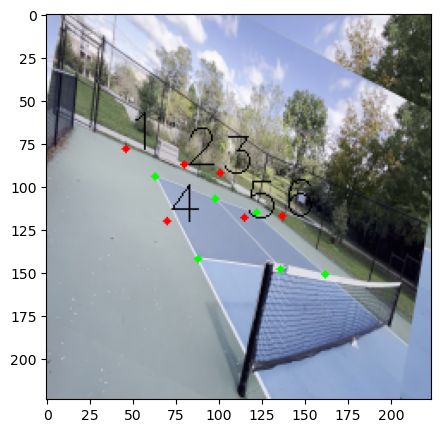

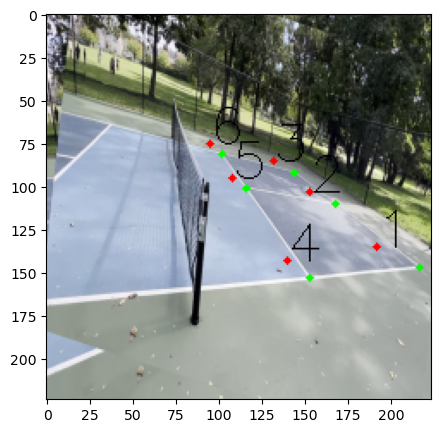

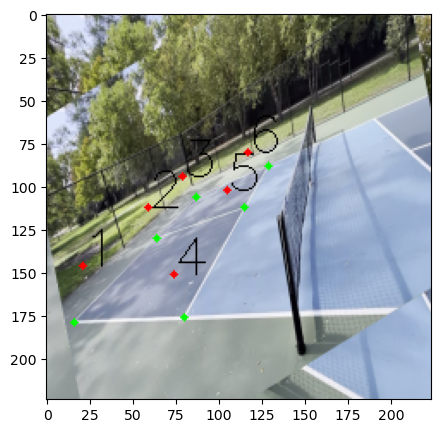

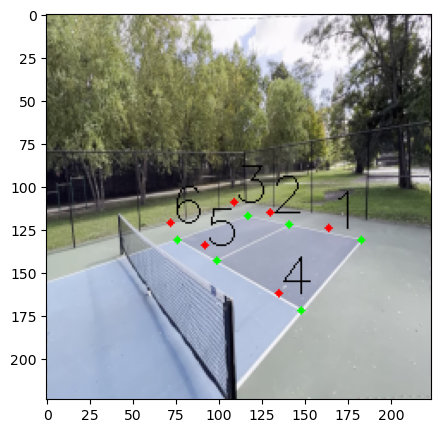

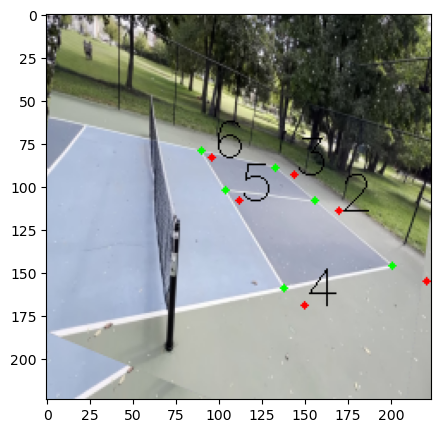

In [38]:
for i in worst_test_indices:
    correct_labels = plot_labels(test_X[i], test_Y[i], withText=False)
    all_labels = plot_labels(correct_labels, test_predictions[i], color=(255,0,0))
    plot_image(all_labels, figsize=(5,5))

## Interactive Testing

In [39]:
from court_segment.plot_court_labels import plot_random_labeled_image

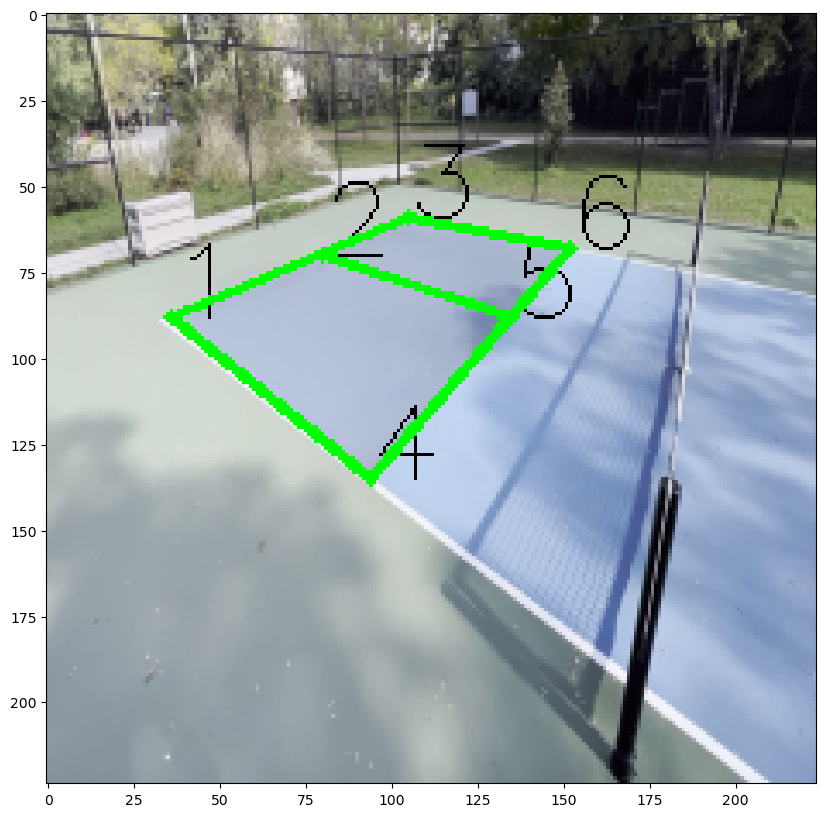

In [40]:
plot_random_labeled_image(train_X, train_predictions, withLines=True)

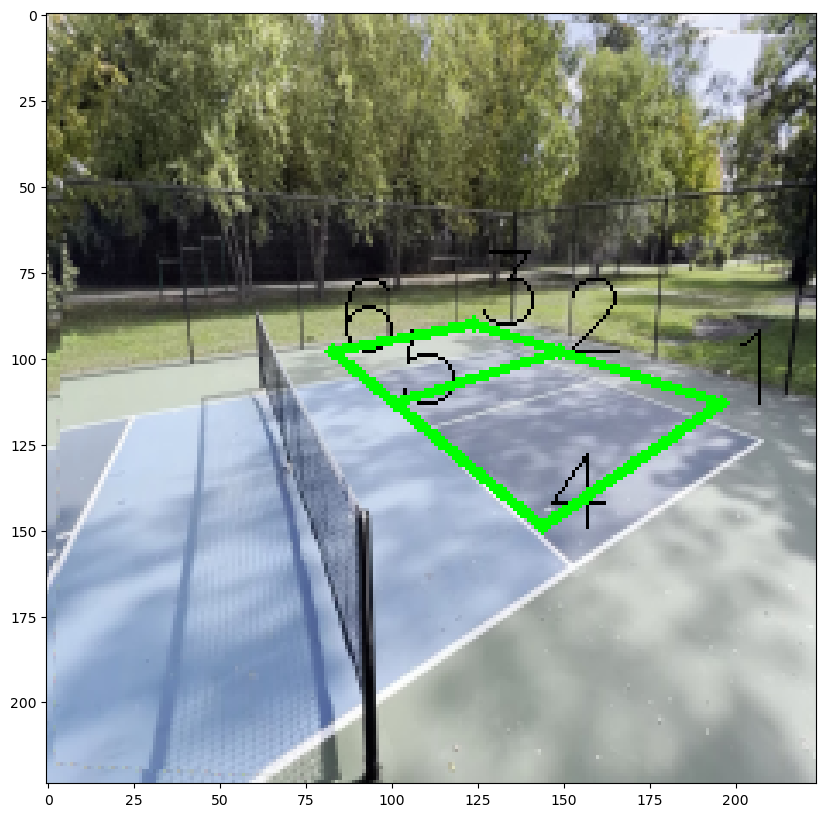

In [85]:
plot_random_labeled_image(test_X, test_predictions, withLines=True)

## Try with new dataset

In [86]:
from tools.image_extract import read_frames
from defs.storage_locs import raw_video_path

In [87]:
frames = [i for i in range(0, 1500, 100)]
vid_path = raw_video_path('court', 'center_left_2_shady.MOV')
X_new = read_frames(vid_path, frames, (train_X.shape[1], train_X.shape[2]))
X_new.shape

(15, 224, 224, 3)

In [88]:
y_new = model.predict(X_new)
y_new.shape

1/1 [==============================] - 0s 373ms/step


(15, 12)

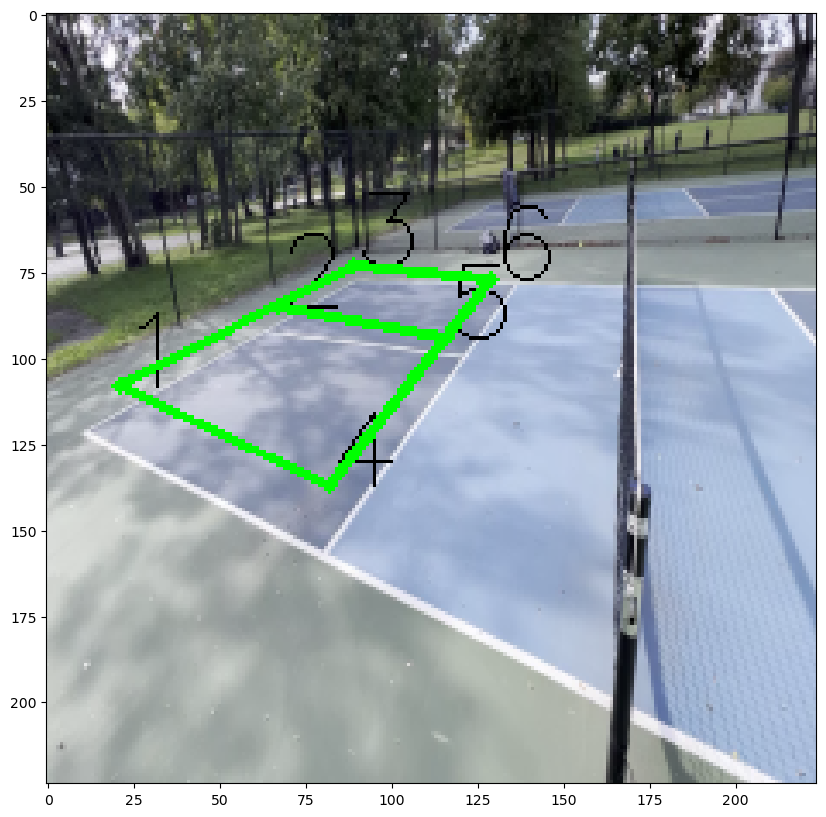

In [118]:
plot_random_labeled_image(X_new, y_new, withLines=True)

horrible...

What about with same dataset but new frames?

In [120]:
frames = [i for i in range(1200, 1500, 50)]
vid_path = raw_video_path('court', 'center_left_1.MOV')
X_new = read_frames(vid_path, frames, train_X.shape[1:3])
X_new.shape

(6, 224, 224, 3)

In [121]:
y_new = model.predict(X_new)

1/1 [==============================] - 0s 392ms/step


In [1]:
plot_random_labeled_image(X_new, y_new, withLines=True)

NameError: name 'plot_random_labeled_image' is not defined